In [1]:
import cv2
from PIL import Image
import numpy as np 
from matplotlib import pyplot as plt
import os
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# https://scikit-image.org/docs/dev/auto_examples/edges/plot_skeleton.html
from skimage.morphology import skeletonize

### Buat fungsi untuk rename file berdasarkan nama file

In [2]:
# rename, berdasarkan nama, untuk dibuat class nya
def split_rename(imgString, separator = '_', indexSplit = 2):
    sp = imgString.split(separator)
    return sp[indexSplit]

### fungsi ROI untuk crop image

In [3]:
def slice_roi(img):
    # convert 0 to 1 , 1 to 0 to find border
    img2 = np.where(img==0, 255, 0)
    
    #axis=0 refer to column, axis=1 refer to row
    
    #find column with value >0 to find left/right border
    img2_col = np.sum(img2, axis = 0)
    col_with_value = np.where(img2_col > 0)[0]
    
    #find row with value >0 to find top/bottom border
    img2_row = np.sum(img2, axis = 1)
    row_with_value = np.where(img2_row > 0)[0]
    
    #get left/right border
    start_col = min(col_with_value)
    end_col = max(col_with_value)
    
    #get top/bottom border
    start_row = min(row_with_value)
    end_row = max(row_with_value)
    
    #get ROI width & height
    roi_width = end_col - start_col
    roi_height = end_row - start_row
    
    #get ROI area
    img = img[start_row:end_row, start_col:end_col]
    
    if roi_width > roi_height:
        diff = roi_width - roi_height
        extra_pad = int(diff/2)
        img = np.pad(img, ((extra_pad, extra_pad), (0,0)), 'maximum')
    else:
        diff = roi_height - roi_width
        extra_pad = int(diff/2)
        img = np.pad(img, ((0,0), (extra_pad, extra_pad)), 'maximum')
        
    return img

### Fungsi rotasi image

In [4]:
def rotate_image(mat, angle):
    """
    Rotates an image (angle in degrees) and expands image to avoid cropping
    """

    # height, width = mat.shape[:2] # image shape has 3 dimensions
    height, width = mat.shape # image shape has 2 dimensions
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0]) 
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))
    return rotated_mat

### Fungsi thinning image (entah kenapa tidak work)

In [5]:
# https://medium.com/analytics-vidhya/skeletonization-in-python-using-opencv-b7fa16867331
def thinning(img):
    
    # Threshold the image
    ret, img = cv2.threshold(img, 127, 255, 0)
    
    # Step 1: Create an empty skeleton
    size = np.size(img)
    skel = np.zeros(img.shape, np.uint8)
    
    # Get a Cross Shaped Kernel
    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
    
    # Repeat steps 2-4
    while True:
        #Step 2: Open the image
        open = cv2.morphologyEx(img, cv2.MORPH_OPEN, element)
        
        #Step 3: Substract open from the original image
        temp = cv2.subtract(img, open)
        
        #Step 4: Erode the original image and refine the skeleton
        eroded = cv2.erode(img, element)
        skel = cv2.bitwise_or(skel,temp)
        img = eroded.copy()
        
        # Step 5: If there are no white pixels left ie.. the image has been completely eroded, quit the loop
        if cv2.countNonZero(img)==0:
            break
        
        return skel
    

### Own Augmentation 

In [1]:
def own_augment(img_array, label, rotation, bordervalue=(255,255,255), scale=None):
    img_augs = []
    labels = []
    
    for index, img in enumerate(img_array):
        img_augs.append(img) # add original image
        labels.append(label[index]) # add label
        for rot in rotation:
            h, w = img.shape
            cX, cY = (w // 2, h // 2)
            
            M = cv2.getRotationMatrix2D((cX, cY), rot, 1.0)
            rotated = cv2.warpAffine(img, M, (w, h), borderValue=bordervalue)
            img_augs.append(rotated) # add augmentation image
            labels.append(label[index]) # add label
        if scale:
            for zoom in scale:
                # procces zooming image
                h, w = img.shape
                scaleX, scaleY = zoom, zoom
                
                img_zoom = cv2.resize(img, (h, w), fx=scaleX, fy=scaleY)
                img_augs.append(img_zoom)
                labels.append(label[index])
    return np.array(img_augs), np.array(labels)

In [7]:
def own_augment_v2(datagen, img_array, label, limit_augs=3, binary=False):
    dataset = []
    labels = []
    for index, img in enumerate(img_array):        
        x = img.reshape( (1, ) + img.shape + (1,))
        
        dataset.append(x)
        labels.append(label[index])
        
        i = 0
        for batch in datagen.flow(x,batch_size=3):
            if binary:
                mean_batch = np.mean(batch)
                batch = np.where(batch > mean_batch, 1, 0)
            dataset.append(batch)
            labels.append(label[index])
            i += 1
            if i >= limit_augs:
                break
    data = np.array(dataset)
    return np.squeeze(data), np.array(labels)

### Load Image

In [8]:
def loadImage(folder, imgType = ['.jpeg', '.jpg'], IMGSIZE = 64, rotasi=0, scale=1.0, binarization=False):
    images = []
    label = []
    # traverse root directory, and list directories as dirs and files as files
    for root, dirs, files in os.walk(folder):
        for filename in os.listdir(root):
            if any([filename.endswith(x) for x in imgType]):
                
                # baca image dan ubah ke grayscale
                img_gray = cv2.imread(os.path.join(root, filename), cv2.IMREAD_GRAYSCALE)
                
#                 # norm image
#                 norm_image = cv2.normalize(img_gray, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                                
                # gunakan ROI untuk crop
                img_roi = slice_roi(img_gray)
                
                # rotate
                img_rotated = rotate_image(img_roi, rotasi)
                
                # Skeletonize
#                 img_rotated = skeletonize(img_rotated)
                
                # Normalisasi (binarization image)
                if binarization:
                    ret, img_rotated = cv2.threshold(img_rotated, 128, 1, cv2.THRESH_BINARY) # batasnya 128, yg dimana diatas 128 dikasi nilai 1 
                
                # Resize ukuran citra
                img = cv2.resize(img_rotated, (IMGSIZE, IMGSIZE))
                
                
                # jika real image
                if img is not None:
                    # adding image
                    images.append(img)
                    # adding label
                    label.append(split_rename(filename))
    
    return np.array(images, dtype=np.uint8), np.array(label) # blum coba untuk typenya antara np.uint8 / np.int32 yg bisa dipakai untuk moment invariant (atau mungkin keduanya)

# Preprocessing

In [9]:
IMAGE_PATH = './Dataset'
# IMAGE_PATH = 'C:\\Users\Mereska\\AnacondaProjects\\TA\\Dataset'
img_extension = ['.jpeg', '.jpg']

In [10]:
img_extract, label_extract = loadImage(IMAGE_PATH, rotasi=0, binarization=False)

In [16]:
# own augment

# img, label = own_augment(img_extract, label_extract, rotation=[-45, 45], bordervalue=(1, 1, 1), scale=[0.9, 0.8]) #binarization image True

img, label = own_augment(img_extract, label_extract, rotation=[-45, -30, 30, 45], bordervalue=(255, 255, 255), scale=[0.9, 0.8]) #binarization image False

In [17]:
# own augment v2

cVAL = 255 # 1 if binary, non binary 255
datagen = ImageDataGenerator(
    rotation_range= 45,
    zoom_range=[0.9, 0.8],
    fill_mode='constant',
    cval=cVAL
)

#img, label = own_augment_v2(datagen, img_extract, label_extract, limit_augs=3, binary=True) #binarization image True


# img, label = own_augment_v2(datagen, img_extract, label_extract, limit_augs=3, binary=False) #binarization image False

In [18]:
print(img.shape)
print(label.shape)

(8100, 64, 64)
(8100,)


In [19]:
# img[0]
# plt.imshow(img[0], cmap='gray')

In [20]:
# import matplotlib.image as mpimg
# mpimg.imsave('a.jpg',img[0], cmap='gray')

## Tampilkan data

In [21]:
# fungsi untuk menampilkan semua gambar

def showImage(images, rows, cols, limit = 0):
    for i in range(0, len(images) if limit == 0 else limit, cols):
        fig = plt.figure(figsize=(16,9))
        for j in range(0, cols if limit == 0 else limit):
            fig.add_subplot(rows, cols, j+1)
            plt.imshow(images[i+j], cmap='gray')
        plt.show()

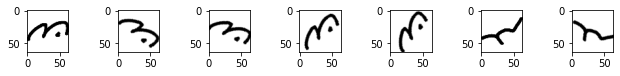

In [22]:
showImage(img, 10, 10, limit = 7)

# Ekstraksi feature hog

In [61]:
from features_extr import hog_feature_extraction, all_glcm_properties, glcm_df

In [62]:
feature_hog = np.array(hog_feature_extraction(img))

In [63]:
feature_hog.shape

(3780, 2916)

In [64]:
feature_hog[0].shape

(2916,)

# Ekstraksi feature glcm

In [65]:
feature_glcm, column = all_glcm_properties(img, label)

In [66]:
np.array(feature_glcm).shape

(3780, 25)

In [67]:
df_glcm = glcm_df(feature_glcm, column)

In [68]:
df_glcm

,dissimilarity_0,dissimilarity_45,dissimilarity_90,dissimilarity_135,correlation_0,correlation_45,correlation_90,correlation_135,homogeneity_0,homogeneity_45,...,contrast_135,ASM_0,ASM_45,ASM_90,ASM_135,energy_0,energy_45,energy_90,energy_135,label
0,0.164195,0.245000,0.197564,0.139444,0.311969,0.036274,0.252784,0.451485,0.917903,0.877500,...,0.139444,0.624120,0.560803,0.577068,0.625779,0.790013,0.748868,0.759650,0.791062,a
1,0.128178,0.213889,0.243644,0.210556,0.488832,0.190564,0.068218,0.203179,0.935911,0.893056,...,0.210556,0.637497,0.567615,0.554236,0.569534,0.798434,0.753402,0.744471,0.754675,a
2,0.242585,0.211667,0.130297,0.214444,0.069665,0.200128,0.481927,0.189631,0.878708,0.894167,...,0.214444,0.555513,0.568510,0.635178,0.566916,0.745327,0.753996,0.796981,0.752938,a
3,0.108581,0.193056,0.184322,0.131389,0.471597,0.111530,0.152764,0.395329,0.945710,0.903472,...,0.131389,0.697721,0.626925,0.632096,0.668584,0.835297,0.791786,0.795044,0.817670,ba
4,0.109110,0.124444,0.165254,0.190556,0.445831,0.399942,0.194202,0.081162,0.945445,0.937778,...,0.190556,0.705905,0.683654,0.656973,0.638368,0.840182,0.826834,0.810539,0.798980,ba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3775,0.181939,0.196389,0.145127,0.234167,0.401240,0.363737,0.515201,0.241345,0.909031,0.901806,...,0.234167,0.547304,0.533520,0.576580,0.512007,0.739800,0.730424,0.759329,0.715547,yo
3776,0.143008,0.231667,0.181144,0.194444,0.520123,0.244808,0.400245,0.366146,0.928496,0.884167,...,0.194444,0.579432,0.515237,0.549639,0.536599,0.761205,0.717800,0.741376,0.732529,yo
3777,0.207097,0.205833,0.193061,0.187500,0.450063,0.452528,0.462686,0.501290,0.896451,0.897083,...,0.187500,0.459208,0.460564,0.484903,0.471686,0.677649,0.678648,0.696350,0.686794,yu
3778,0.145127,0.188611,0.150953,0.204167,0.565430,0.450185,0.557194,0.404839,0.927436,0.905694,...,0.204167,0.541979,0.503919,0.530932,0.494473,0.736192,0.709872,0.728651,0.703188,yu


# Ekstraksi feature (moment invariant)

In [23]:
#moment inv
def momentInvariantFeature(img):
    moments = cv2.moments(img)
    huMoment = cv2.HuMoments(moments)
    
    return huMoment.flatten().tolist()

In [24]:
# looping for entire image
def feature_extraction(img_array):
    feature = []
    for i in range(len(img_array)):
        feature.append(momentInvariantFeature(img_array[i]))
    return feature

In [25]:
feature_im = np.array(feature_extraction(img.astype(np.float32)))

# save to csv (feature with label)

In [26]:
# Create function to concate another feature
def concatenate_feature(df1, df2, axis=0, rename_index=True):
    # 0 vertical (menurun)
    # 1 horizonal (kesamping)
    return pd.concat([df1, df2], axis=axis, ignore_index=rename_index)

In [27]:
def oneHotEncoder(label):
    # label with one hot encoding
    label = np.array(label).reshape(-1,1) # ubah ke bentuk (-1,1) sesuai yang diinginkan oleh onehotencoder
    onehot_encoder = OneHotEncoder()
    y = onehot_encoder.fit_transform(label).toarray()
    # onehot_encoder.categories_
    df_label = pd.DataFrame(data=y, columns=[str(onehot_encoder.categories_[0][i]) for i in range(np.array(y).shape[1])])
    
    return df_label

In [28]:
# add label in end of feature
def mInvariant_mixin_feature_and_label(feature, label, encoder=False):
    # feaature
    dt = pd.DataFrame(data=feature, columns=["M"+str(i+1) for i in range(np.array(feature).shape[1])], dtype=np.float64)
    if(encoder == False):
        dt['label'] = label
        return dt
    else:
        df_label = oneHotEncoder(label)
        # gabungin dataframenya
        df = pd.concat([dt, df_label], axis=1)
        return df

In [29]:
# function feature to csv with label
def save_to_csv(data):
    now = datetime.now()
    dt_string = now.strftime("%d-%m-%Y_%H-%M-%S") + "_feature.csv"
    data.to_csv(dt_string, header=True, index = False)

In [30]:
# moment invariant
data_im = mInvariant_mixin_feature_and_label(feature_im, label, encoder=False)

In [ ]:
# glcm combine im
data_glcm = df_glcm.drop(columns=["label"])
data2 = concatenate_feature(data_glcm, data_im, axis=1, rename_index=False)

In [33]:
# save_to_csv(data_im)

In [31]:
data_im

,M1,M2,M3,M4,M5,M6,M7,label
0,0.000811,3.754003e-09,1.012610e-13,3.743107e-13,7.259493e-26,1.615691e-17,6.365473e-27,a
1,0.000810,3.718497e-09,1.876618e-13,4.889818e-13,1.481005e-25,2.189295e-17,-2.668590e-27,a
2,0.000809,3.140893e-09,2.104193e-13,4.520823e-13,1.391068e-25,1.800322e-17,-9.548787e-27,a
3,0.000812,3.727553e-09,5.493144e-14,3.434100e-13,4.680824e-26,1.518252e-17,5.799136e-27,a
4,0.000812,3.561092e-09,6.282719e-14,3.487532e-13,5.162372e-26,1.523749e-17,1.493970e-28,a
...,...,...,...,...,...,...,...,...
8095,0.000915,7.192533e-09,8.602930e-13,7.110001e-12,-4.376506e-24,-5.213533e-16,1.703108e-23,yu
8096,0.000903,2.168113e-09,7.538334e-13,6.727534e-12,-2.044912e-24,-3.064958e-16,1.501167e-23,yu
8097,0.000908,4.187452e-09,4.997341e-13,6.580165e-12,-3.122308e-24,-3.883052e-16,1.151657e-23,yu
8098,0.000906,1.464943e-09,9.064897e-13,6.908521e-12,-9.933016e-25,-2.642237e-16,1.726001e-23,yu
